<a href="https://colab.research.google.com/github/Trapti0603/M31-Dark-matter-modelling/blob/main/Hernquist_and_Einasto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install emcee corner

100%|██████████| 5000/5000 [10:42:17<00:00,  7.71s/it]


Shape of samples: (200000, 6)
 M31 : Hernquist profile best-fit parameters:
a_b = 1.196 ± 0.093
sigma_b = 7.030e+08 ± 4.335e+07
a_d = 4.725 ± 0.258
sigma_d = 4.259e+08 ± 3.971e+07
rho_0 = 1.808e+07 ± 7.969e+05
h = 18.610 ± 1.368
Mean acceptance fraction: 0.005836000000000001
Autocorrelation time: [23.18086547 26.50958346 82.30820932 79.29982007 69.48887327 75.87156542]


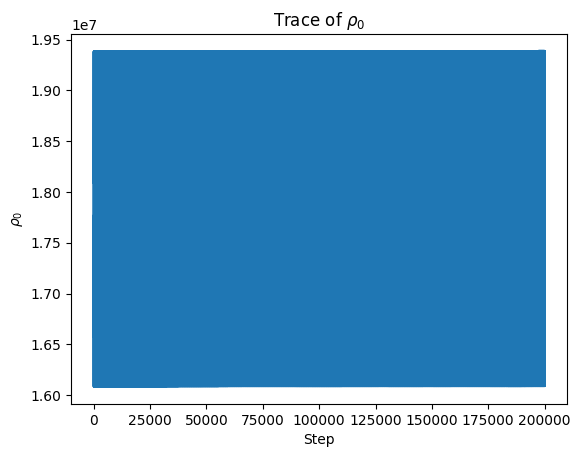

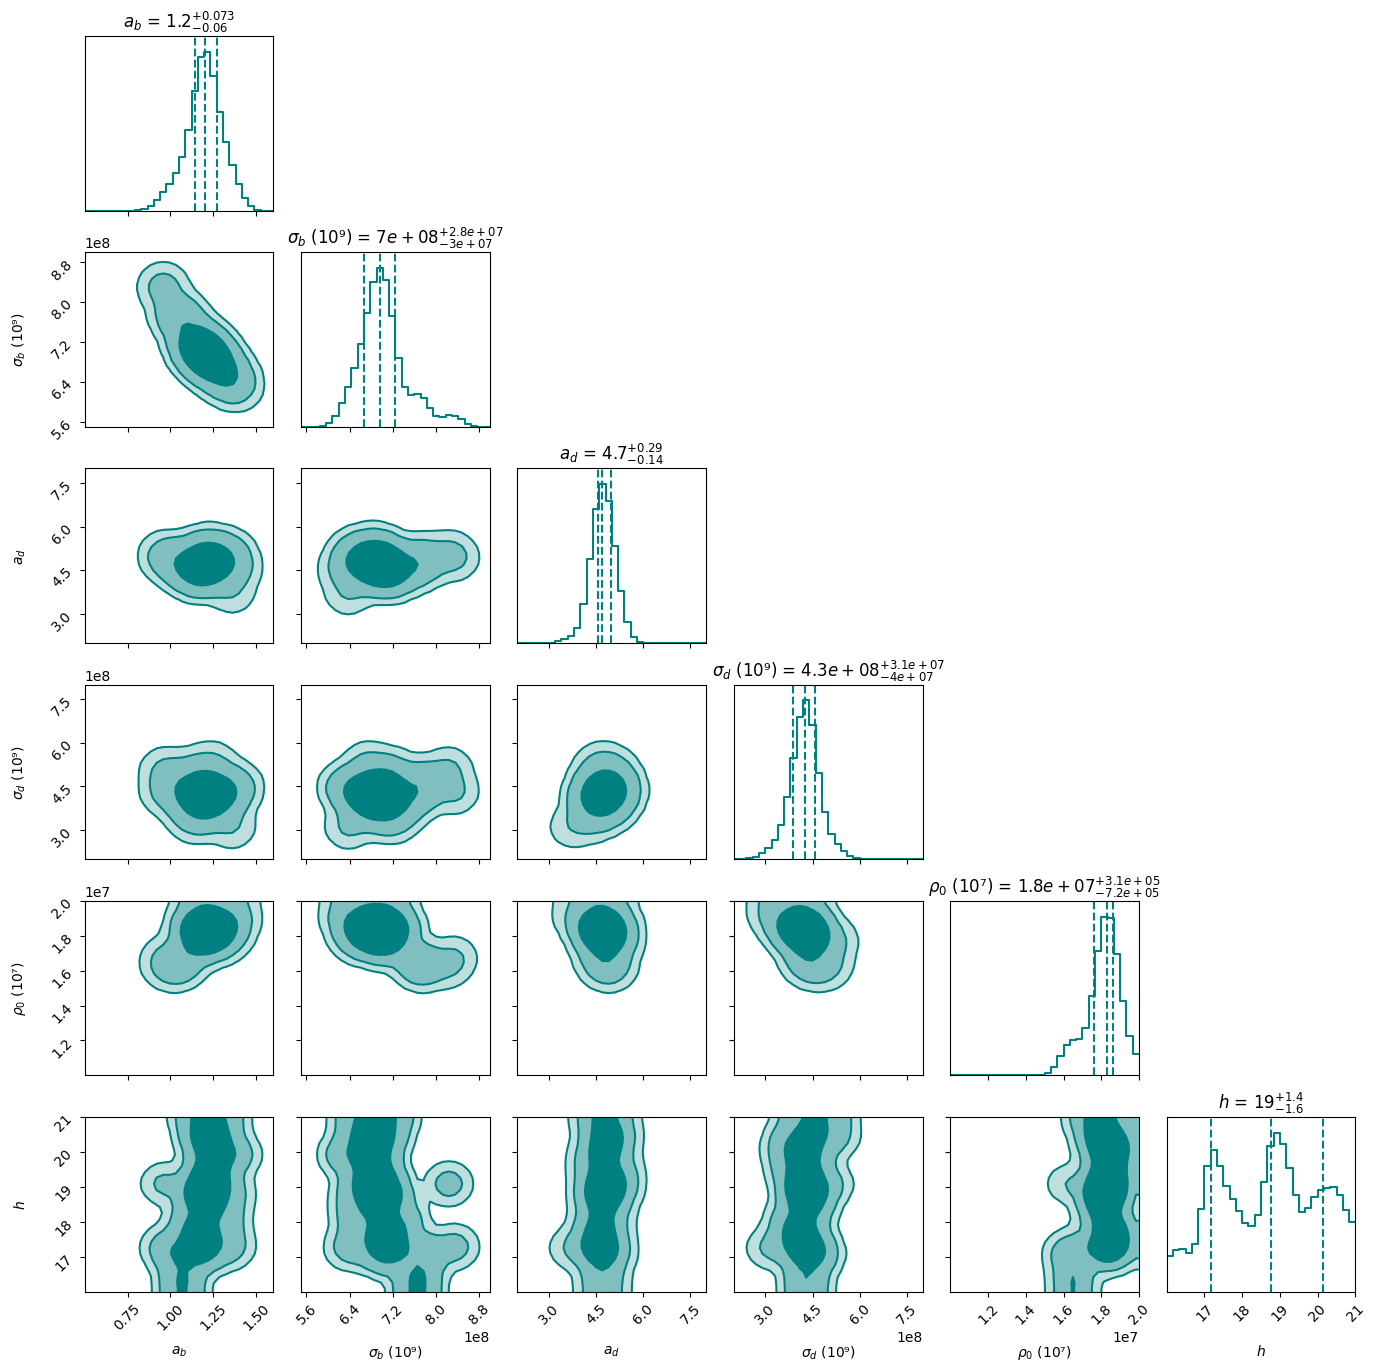

In [ ]:
import pandas as pd, matplotlib.pyplot as plt, numpy as np
from scipy.special import iv, kv , gammainc, gamma
import emcee, multiprocessing, time, corner
from numba import njit

# Constants
k = 7.6695
G = 4.302e-6

# Load M31 rotation curve data
data = pd.read_csv("M31_Grand_Rotation_Curve.csv")
xl = np.array(data['R (kpc)'])
yl = np.array(data['Vc (km/s)'])
el = np.array(data['Vc error (km/s)'])

# --- Bulge Component ---
@njit
def sigbr_x(x, sig_b, a_b):
    return sig_b * np.exp(-k * ((x / a_b)**0.25 - 1))

@njit
def dsigbr_x_dx(x, sig_b, a_b):
    prefactor = -(k / 4) * (1 / a_b)**0.25 * x**(-0.75)
    return prefactor * sigbr_x(x, sig_b, a_b)

@njit
def rho_bulge_numba(r, a_b, sig_b):
    result = 0.0
    du = (20.0 - 0.01) / 200
    for i in range(201):
        u = 0.01 + i * du
        x = r * np.cosh(u)
        integrand = dsigbr_x_dx(x, sig_b, a_b)
        weight = 1.0
        if i == 0 or i == 200:
            weight = 0.5
        result += weight * integrand
    integral = result * du
    return -integral / np.pi

@njit
def vb_numba(r, a_b, sig_b):
    if r <= 1e-5:
        return 0.0
    result = 0.0
    dr = (r - 0.01) / 200
    for i in range(201):
        ri = 0.01 + i * dr
        integrand = rho_bulge_numba(ri, a_b, sig_b) * ri**2
        weight = 1.0
        if i == 0 or i == 200:
            weight = 0.5
        result += weight * integrand
    integral = result * dr
    vb2 = (4 * np.pi * G / r) * integral
    return np.sqrt(vb2) if vb2 > 0 else 0.0

# --- Disk Component ---
def vd_generic(r, a_d, sig_d):
    r = np.atleast_1d(r)
    r = np.where(r <= 1e-5, 1e-5, r)
    v2 = np.zeros_like(r)
    x = r / (2 * a_d)
    term = iv(0, x) * kv(0, x) - iv(1, x) * kv(1, x)
    v2_val = np.pi * G * sig_d * (r**2 / a_d) * term
    v2 = np.where(v2_val > 0, v2_val, 0.0)
    v = np.sqrt(v2)
    return float(v) if v.shape == (1,) else v

# --- Halo Component (Hernquist) ---
def vh_hern_vec(r, rho, h):
    r = np.atleast_1d(r)
    r = np.where(r <= 1e-5, 1e-5, r)
    x = r / h
    v2 = G * 2 * np.pi * rho * h * r / (1 + x)**2
    v2 = np.where(v2 > 0, v2, 0.0)
    v = np.sqrt(v2)
    return float(v) if v.shape == (1,) else v

# --- Likelihood, Prior, Posterior ---
def ln_likeli_hern(xl, yl, el, a_b, sig_b, a_d, sig_d, rho, h):
    try:
        vbulge = np.array([vb_numba(x, a_b, sig_b) for x in xl])
        vdisk  = np.array([vd_generic(x, a_d, sig_d) for x in xl])
        vhalo  = np.array([vh_hern_vec(x, rho, h) for x in xl])
        vth2 = vbulge**2 + vdisk**2 + vhalo**2
        if not np.all(np.isfinite(vth2)) or np.any(vth2 < 0):
            return -np.inf
        vth = np.sqrt(vth2)
        chi2 = np.sum((yl - vth)**2 / el**2)
        return -0.5 * chi2
    except:
        return -np.inf

def ln_prior_hern(theta):
    a_b, sig_b, a_d, sig_d, rho, h = theta
    if not (0.9 < a_b < 1.6): return -np.inf
    if not (0.5e9 < sig_b < 0.9e9): return -np.inf
    if not (2 < a_d < 8): return -np.inf
    if not (0.1e9 < sig_d < 0.8e9): return -np.inf
    if not (1e7 < rho < 2.2e7): return -np.inf
    if not (15 < h < 21): return -np.inf
    return 0.0

def ln_post_hern(theta, xl, yl, el):
    a_b, sig_b, a_d, sig_d, rho, h = theta

    # Check prior first
    if not (0.9 < a_b < 1.6 and 0.5e9 < sig_b < 0.9e9 and
            2 < a_d < 8 and 0.1e9 < sig_d < 0.8e9 and
            1e7 < rho < 2.2e7 and 15 < h < 21):
        return -np.inf

    try:
        # Precompute once for better performance
        r_safe = np.where(xl <= 1e-4, 1e-4, xl)
        vbulge = np.array([vb_numba(r, a_b, sig_b) for r in r_safe])
        vdisk  = vd_generic(r_safe, a_d, sig_d)
        vhalo  = vh_hern_vec(r_safe, rho, h)
        v2 = vbulge**2 + vdisk**2 + vhalo**2

        # Check invalid entries
        if not np.all(np.isfinite(v2)) or np.any(v2 < 0):
            return -np.inf

        vmodel = np.sqrt(v2)
        safe_el = np.where(el <= 1e-6, 1e-6, el)
        chi2 = np.sum(((yl - vmodel) / safe_el)**2)

        return -0.5 * chi2
    except Exception:
        return -np.inf

# --- Initial Guess Debug Check ---
init_guess = [1.252, 0.713e9, 4.814, 0.439e9, 1.799e7, 18.833]
spread = [0.03, 0.015e9, 0.1, 0.015e9, 0.2e6, 0.5]
# === Fast and safe walker setup ===
valid_pos = []
while len(valid_pos) < nwalkers:
    trial = init_guess + np.random.normal(0, spread)
    if np.isfinite(ln_post_hern(trial, xl, yl, el)):
        valid_pos.append(trial)
pos = np.array(valid_pos)

# --- MCMC Setup ---
ndim, nwalkers, nsteps, burnin = 6, 50, 5000, 1000
pos = init_guess + np.random.normal(0, spread, size=(nwalkers, ndim))

# --- MCMC Execution ---
if __name__ == '__main__':
    with multiprocessing.Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post_hern, args=(xl, yl, el), pool=pool)
        sampler.run_mcmc(pos, nsteps, progress=True)

    flat_samples = sampler.get_chain(discard=burnin, flat=True)
    print("Shape of samples:", flat_samples.shape)

    ab_samp, sb_samp = flat_samples[:, 0], flat_samples[:, 1]
    ad_samp, sd_samp = flat_samples[:, 2], flat_samples[:, 3]
    rho_samp, h_samp = flat_samples[:, 4], flat_samples[:, 5]

    print(" M31 : Hernquist profile best-fit parameters:")
    print(f"a_b = {np.mean(ab_samp):.3f} ± {np.std(ab_samp):.3f}")
    print(f"sigma_b = {np.mean(sb_samp):.3e} ± {np.std(sb_samp):.3e}")
    print(f"a_d = {np.mean(ad_samp):.3f} ± {np.std(ad_samp):.3f}")
    print(f"sigma_d = {np.mean(sd_samp):.3e} ± {np.std(sd_samp):.3e}")
    print(f"rho_0 = {np.mean(rho_samp):.3e} ± {np.std(rho_samp):.3e}")
    print(f"h = {np.mean(h_samp):.3f} ± {np.std(h_samp):.3f}")
    print("Mean acceptance fraction:", np.mean(sampler.acceptance_fraction))
    try:
        print("Autocorrelation time:", sampler.get_autocorr_time())
    except:
        print("Autocorrelation time could not be estimated (chain may not have converged).")

    # --- Plotting ---
    plt.plot(rho_samp)
    plt.title("Trace of $\\rho_0$")
    plt.xlabel("Step")
    plt.ylabel("$\\rho_0$")

    corner.corner(
        flat_samples,
        labels=["$a_b$", "$\\sigma_b$ (10⁹)", "$a_d$", "$\\sigma_d$ (10⁹)", "$\\rho_0$ (10⁷)", "$h$"],
        bins=30,
        color="teal",
        quantiles=[0.16, 0.5, 0.84],
        plot_contours=True,
        fill_contours=True,
        levels=(0.68, 0.95, 0.99),
        plot_datapoints=False,
        smooth=2.0, smooth1d=1.5,
        title_fmt=".2g",
        show_titles=True,
        range=[(0.5,1.6), (0.55e9, 0.9e9), (2, 8), (0.2e9, 0.8e9), (1e7,2e7), (16,21)]
    )
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner
from numba import njit
from scipy.special import iv, kv, gammainc, gamma
import multiprocessing, time

# Constants
G = 4.302e-6  # kpc·(km/s)^2 / M_sun
k = 7.6695    # Sérsic constant

# Load Data
data = pd.read_csv("M31_Grand_Rotation_Curve.csv")
xl = np.array(data['R (kpc)'])
yl = np.array(data['Vc (km/s)'])
el = np.array(data['Vc error (km/s)'])

# Bulge profile
@njit
def sigbr_x(x, sig_b, a_b):
    return sig_b * np.exp(-k * ((x / a_b)**0.25 - 1))

@njit
def dsigbr_x_dx(x, sig_b, a_b):
    prefactor = -(k / 4) * (1 / a_b)**0.25 * x**(-0.75)
    return prefactor * sigbr_x(x, sig_b, a_b)

@njit
def rho_bulge_numba(r, a_b, sig_b):
    result = 0.0
    du = (20.0 - 0.01) / 200
    for i in range(201):
        u = 0.01 + i * du
        x = r * np.cosh(u)
        integrand = dsigbr_x_dx(x, sig_b, a_b)
        weight = 0.5 if i == 0 or i == 200 else 1.0
        result += weight * integrand
    return -result * du / np.pi

@njit
def vb_numba(r, a_b, sig_b):
    if r <= 0:
        return 0.0
    dr = (r - 0.01) / 200
    result = 0.0
    for i in range(201):
        ri = 0.01 + i * dr
        integrand = rho_bulge_numba(ri, a_b, sig_b) * ri**2
        weight = 0.5 if i == 0 or i == 200 else 1.0
        result += weight * integrand
    vb2 = (4 * np.pi * G / r) * result * dr
    return np.sqrt(vb2) if vb2 > 0 else 0.0

# Disk profile
def vd_generic(r, a_d, sig_d):
    r = np.atleast_1d(r)
    valid = r > 0
    v2 = np.zeros_like(r)
    x = r[valid] / (2 * a_d)
    term = iv(0, x) * kv(0, x) - iv(1, x) * kv(1, x)
    v2_val = np.pi * G * sig_d * (r[valid]**2 / a_d) * term
    v2[valid] = np.where(v2_val > 0, v2_val, 0.0)
    v = np.sqrt(v2)
    return float(v) if v.shape == (1,) else v

# Einasto halo velocity profile
def vh_ein_vec(r, rho_0, h, n):
    r = np.atleast_1d(r)
    r = np.where(r <= 1e-5, 1e-5, r)
    x = (r / h)**(1 / n)
    mass = 4 * np.pi * rho_0 * n * h**3 * gamma(3 * n) * gammainc(3 * n, x)
    v2 = G * mass / r
    v2 = np.where(v2 > 0, v2, 0.0)
    v = np.sqrt(v2)
    return float(v) if v.shape == (1,) else v

# Likelihood
def ln_likeli_ein(xl, yl, el, a_b, sig_b, a_d, sig_d, rho_0, h, n):
    try:
        r_safe = np.where(xl <= 1e-4, 1e-4, xl)
        vbulge = np.array([vb_numba(r, a_b, sig_b) for r in r_safe])
        vdisk = vd_generic(r_safe, a_d, sig_d)
        vhalo = vh_ein_vec(r_safe, rho_0, h, n)
        v2 = vbulge**2 + vdisk**2 + vhalo**2
        if not np.all(np.isfinite(v2)) or np.any(v2 < 0): return -np.inf
        vmodel = np.sqrt(v2)
        safe_el = np.where(el <= 1e-6, 1e-6, el)
        chi2 = np.sum(((yl - vmodel) / safe_el)**2)
        return -0.5 * chi2
    except:
        return -np.inf

# Prior
def ln_prior_ein(theta):
    a_b, sig_b, a_d, sig_d, rho_0, h, n = theta
    if not (0.9 < a_b < 1.6): return -np.inf
    if not (0.5e9 < sig_b < 0.9e9): return -np.inf
    if not (2 < a_d < 8): return -np.inf
    if not (0.1e9 < sig_d < 0.8e9): return -np.inf
    if not (1e7 < rho_0 < 2e7): return -np.inf
    if not (10 < h < 30): return -np.inf
    if not (3 < n < 8): return -np.inf
    return 0.0

# Posterior
def ln_post_ein(theta, xl, yl, el):
    lp = ln_prior_ein(theta)
    return lp + ln_likeli_ein(xl, yl, el, *theta) if np.isfinite(lp) else -np.inf

# Initial setup
ndim = 7
nwalkers = 60
nsteps = 5000
burnin = 1000
init_guess = [1.252, 0.713e9, 4.814, 0.439e9, 1.799e7, 18.833, 5.0]
spread = [0.02, 0.02e9, 0.1, 0.015e9, 0.2e6, 1.0, 0.3]

# Safe walker initialization
valid_pos = []
while len(valid_pos) < nwalkers:
    trial = init_guess + np.random.normal(0, spread)
    if np.isfinite(ln_post_ein(trial, xl, yl, el)):
        valid_pos.append(trial)
pos = np.array(valid_pos)

# Run MCMC
if __name__ == "__main__":
    with multiprocessing.Pool() as pool:
        sampler_ein = emcee.EnsembleSampler(
            nwalkers, ndim, ln_post_ein, args=(xl, yl, el), pool=pool
        )
        sampler_ein.run_mcmc(pos, nsteps, progress=True)

    flat_samples = sampler_ein.get_chain(discard=burnin, flat=True)
    print("Shape of samples:", flat_samples.shape)

    means = np.mean(flat_samples, axis=0)
    stds = np.std(flat_samples, axis=0)
    labels = ["$a_b$", "$\\sigma_b$", "$a_d$", "$\\sigma_d$", "$\\rho_0$", "$h$", "$n$"]

    for i, label in enumerate(labels):
        print(f"{label} = {means[i]:.3g} ± {stds[i]:.3g}")
    print("Mean acceptance fraction:", np.mean(sampler_ein.acceptance_fraction))

    try:
        tau = sampler_ein.get_autocorr_time()
        print("Autocorrelation time:", tau)
    except:
        print("Autocorrelation time could not be estimated.")

    corner.corner(
        flat_samples,
        labels=labels,
        quantiles=[0.16, 0.5, 0.84],
        levels=(0.68, 0.95),
        show_titles=True,
        smooth=2.0,
        bins=30,
        color="teal"
    )
    plt.tight_layout()
    plt.show()


ModuleNotFoundError: No module named 'emcee'